## This script is to read in the English dataset, pre-process it for LSTM models, then build LSTM models on top for training and inferencing and then infer the translation for the English text.

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [1]:
# Standard imports
import pandas as pd
import numpy as np
import re
import pickle
import string

# Visualization library
import seaborn as sns
import matplotlib.pyplot as plt

# NLP library
from nltk.tokenize import word_tokenize


In [2]:
from numpy.random import seed
seed(42)

In [3]:
#Reading in the English lines dataset
df = pd.read_csv('./data/eng.csv')

In [4]:
df.head()

,Unnamed: 0,eng,eng_len,word_count,eng_pre,eng_post
0,12267,a dog has four legs,19,5,a dog has,four legs
1,12268,a lion is an animal,19,5,a lion is,an animal
2,12269,a noise woke her up,19,5,a noise woke,her up
3,12270,a nurse wears white,19,4,a nurse,white
4,12271,a truck hit the dog,19,5,a truck hit,the dog


In [5]:
#Dropping unnecessary columns
df.drop(columns=['Unnamed: 0', 'eng', 'eng_len', 'word_count'], inplace=True)
df.head()

,eng_pre,eng_post
0,a dog has,four legs
1,a lion is,an animal
2,a noise woke,her up
3,a nurse,white
4,a truck hit,the dog


In [6]:
#Converting to list for the model
data = df.values.tolist()

# Examining the first 5 rows
data[:5]

[['a dog has', 'four legs'],
 ['a lion is', 'an animal'],
 ['a noise woke', 'her up'],
 ['a nurse', 'white'],
 ['a truck hit', 'the dog']]

In [7]:
len(data)

72080

## Modeling is attributed to  https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html. 

In [8]:
# Building empty lists to hold sentences
input_docs = []
target_docs = []
# Building empty vocabulary sets
input_tokens = set()
target_tokens = set()

# Setting the number of lines to use. This is mainly limited by memory errors that pop up when trying to optimize later
n = 40000

for line in data[:n]:
    # Defining an input document and a target document
    input_doc, target_doc = line[0], line[1]
    
    # Appending each input sentence to input_docs
    input_docs.append(input_doc)
    
    # Formatting target documents
    # Splitting words from punctuation  
    target_doc = " ".join(re.findall(r"[\w']+|[^\s\w]", target_doc))
    # Adding <START> and <END> tags
    target_doc = '<START> ' + target_doc + ' <END>'
    # Appending each formated target to target documents
    target_docs.append(target_doc)
  
    # Splitting each sentence into words and adding to vocabulary
    for token in re.findall(r"[\w']+|[^\s\w]", input_doc):
        if token not in input_tokens:
            input_tokens.add(token)
    
    for token in target_doc.split():
        if token not in target_tokens:
            target_tokens.add(token)

In [9]:
#Confirm above code worked as expected
print(input_docs[0])
print(target_docs[0])

a dog has
<START> four legs <END>


In [10]:
# Creating a sorted list of all input tokens and target tokens
input_tokens = sorted(list(input_tokens))
target_tokens = sorted(list(target_tokens))

# Saving the length of vocabulary sets as variables. Encoder and Decoder
num_encoder_tokens = len(input_tokens)
num_decoder_tokens = len(target_tokens)

# Finding the maximum length of an input sentence and target sentence
max_encoder_seq_length = max([len(re.findall(r"[\w']+|[^\s\w]", input_doc)) for input_doc in input_docs])
max_decoder_seq_length = max([len(re.findall(r"[\w']+|[^\s\w]", target_doc)) for target_doc in target_docs])

In [13]:
print(input_tokens[:5], target_tokens[:5])

['a', 'aardvark', 'aardvarks', 'abandon', 'abandoned'] ['<END>', '<START>', 'a', 'aardvark', 'aaron']


In [14]:
# Print some key dimensions - these need to be used later for enabling model-continued training as well as getting translations
print(f'Number of Encoder Tokens: {num_encoder_tokens}')
print(f'Number of Decoder Tokens: {num_decoder_tokens}')
print(f'Maximum Encoder Sequence Length: {max_encoder_seq_length}')
print(f'Maximum Decoder Sequence Length: {max_decoder_seq_length}')

Number of Encoder Tokens: 4872
Number of Decoder Tokens: 6030
Maximum Encoder Sequence Length: 8
Maximum Decoder Sequence Length: 13


# Below code is to create dictionaries between the word and token number for input and target

In [15]:
# Creating four dictionaries
#Input features dict - is a dictionary with input word as key pointing to token #
#Target features dict - is a dictionary with target word as key pointing to token #
#Reverse Input features dict - is a dictionary with token# as key pointing to input word
#Reverse Target features dict - is a dictionary with token# as key pointing to target word


input_features_dict = dict(
    [(token, i) for i, token in enumerate(input_tokens)])
target_features_dict = dict(
    [(token, i) for i, token in enumerate(target_tokens)])

# Creating the reverse 
reverse_input_features_dict = dict(
    (i, token) for token, i in input_features_dict.items())
reverse_target_features_dict = dict(
    (i, token) for token, i in target_features_dict.items())

# Storing the dictionaries so it can be used for continued training and inferencing later

In [16]:
import pickle

with open('./data/rtfd.p', 'wb') as fp:
    pickle.dump(reverse_target_features_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('./data/tfd.p', 'wb') as fp:
    pickle.dump(target_features_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('./data/rifd.p', 'wb') as fp:
    pickle.dump(reverse_input_features_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('./data/ifd.p', 'wb') as fp:
    pickle.dump(input_features_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [17]:
# Checking English index and word dictionary
first2pairs = {k: reverse_input_features_dict[k] for k in list(reverse_input_features_dict)[:2]}
first2pairs

{0: 'a', 1: 'aardvark'}

In [18]:
# Checking English input word and index dictionary
first2pairs = {k: input_features_dict[k] for k in list(input_features_dict)[:2]}
first2pairs

{'a': 0, 'aardvark': 1}

In [19]:
# Checking index & English target word dictionary
firstfewpairs = {k: reverse_target_features_dict[k] for k in list(reverse_target_features_dict)[2:8]}
firstfewpairs

{2: 'a', 3: 'aardvark', 4: 'aaron', 5: 'aback', 6: 'abandon', 7: 'abandoned'}

In [20]:
# Checking English target word and index dictionary
firstfewpairs = {k: target_features_dict[k] for k in list(target_features_dict)[2:8]}
firstfewpairs

{'a': 2, 'aardvark': 3, 'aaron': 4, 'aback': 5, 'abandon': 6, 'abandoned': 7}

In [21]:
# Creating empty matricies for input data
encoder_input_data = np.zeros(
    (len(input_docs), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_docs), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_docs), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

In [22]:
print(f'Encoder Input Data Shape: {encoder_input_data.shape}')
print(f'Decoder Input Data Shape: {decoder_input_data.shape}')
print(f'Decoder Target Data Shape: {decoder_target_data.shape}')

Encoder Input Data Shape: (40000, 8, 4872)
Decoder Input Data Shape: (40000, 13, 6030)
Decoder Target Data Shape: (40000, 13, 6030)


In [20]:
# This block of code sets up our data for input to the neural net.

for line, (input_doc, target_doc) in enumerate(zip(input_docs, target_docs)):

    for timestep, token in enumerate(re.findall(r"[\w']+|[^\s\w]", input_doc)):
        # Assigning 1.0 for the current line, timestep, & word in encoder_input_data:
        encoder_input_data[line, timestep, input_features_dict[token]] = 1.0
        # Potential Conditional Statement

    for timestep, token in enumerate(target_doc.split()):
        # Assigning 1.0 for same in decoder_input_data
        decoder_input_data[line, timestep, target_features_dict[token]] = 1.0
        if timestep > 0:
            
            # Setting the decoder target data for 1 previous timestep
            decoder_target_data[line, timestep - 1, target_features_dict[token]] = 1.0

In [21]:
#Checking sample word in matrix
np.argmax(encoder_input_data[10])

151

In [22]:
#Confirming word was read correctly
reverse_input_features_dict[151]

'aluminum'

In [23]:
print(num_encoder_tokens, num_decoder_tokens, max_encoder_seq_length, max_decoder_seq_length)

4872 6030 8 13


## LSTM MODEL BUILD TO START FROM HERE

In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, LSTM, Dense, Masking
from tensorflow.keras.models import Model, save_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.backend import manual_variable_initialization #was added to ensure model can be loaded correctly later
manual_variable_initialization(True)

import os

In [25]:
tf.random.set_seed(42)

## Defining the model Structure

In [26]:
#Defining the model structure
latent_dim = 256 ### Would have liked to increase this, but memory and run-time issues caused me to cap

# Encoder training setup
encoder_inputs = Input(shape=(None, num_encoder_tokens))

encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs) 
encoder_states = [state_h, state_c]

# Decoder training setup:
decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs,_ ,_ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [27]:
epochs = 55
batch_size = 128

#callback = EarlyStopping(monitor='val_accuracy', patience=4) #Was turned off since model was improving gradually

training_model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

training_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'], sample_weight_mode='temporal')

#Turn checkpoint on so that interim model run results can be used if system crashes, saved every 5 epochs
model_checkpoint= ModelCheckpoint('./models/endspan{epoch:02d}.h5',period=5,save_weights_only=False)

history = training_model.fit([encoder_input_data, decoder_input_data], decoder_target_data, 
                    batch_size = batch_size, 
                    epochs = epochs, 
                    callbacks=[model_checkpoint],         
                    validation_split = 0.2)
                    #callbacks = callback)


Epoch 1/55
250/250 [==============================] - 148s 575ms/step - loss: 1.4291 - accuracy: 0.8106 - val_loss: 1.9250 - val_accuracy: 0.7462
Epoch 2/55
250/250 [==============================] - 140s 558ms/step - loss: 1.3350 - accuracy: 0.8310 - val_loss: 1.9127 - val_accuracy: 0.7537
Epoch 3/55
250/250 [==============================] - 138s 552ms/step - loss: 1.3165 - accuracy: 0.8350 - val_loss: 1.8967 - val_accuracy: 0.7555
Epoch 4/55
250/250 [==============================] - 139s 558ms/step - loss: 1.3042 - accuracy: 0.8363 - val_loss: 1.8798 - val_accuracy: 0.7558
Epoch 5/55
250/250 [==============================] - 139s 557ms/step - loss: 1.2908 - accuracy: 0.8373 - val_loss: 1.8648 - val_accuracy: 0.7572
Epoch 6/55
250/250 [==============================] - 139s 556ms/step - loss: 1.2830 - accuracy: 0.8376 - val_loss: 1.8472 - val_accuracy: 0.7605
Epoch 7/55
250/250 [==============================] - 139s 555ms/step - loss: 1.2670 - accuracy: 0.8393 - val_loss: 1.8232 -

In [28]:
#Saving the model so we can use later
#tf.saved_model.save(training_model, './models/')
training_model.save('./models/training_model_gcp.h5')

In [42]:
epochs = 25
history2 = training_model.fit([encoder_input_data, decoder_input_data], decoder_target_data, 
                    batch_size = batch_size, 
                    epochs = epochs, 
                    callbacks=[model_checkpoint],         
                    validation_split = 0.2)
                    #callbacks = callback)


Epoch 1/25
188/188 [==============================] - 86s 456ms/step - loss: 1.1182 - accuracy: 0.8581 - val_loss: 1.5673 - val_accuracy: 0.8029
Epoch 2/25
188/188 [==============================] - 82s 437ms/step - loss: 1.1119 - accuracy: 0.8590 - val_loss: 1.5537 - val_accuracy: 0.8037
Epoch 3/25
188/188 [==============================] - 83s 439ms/step - loss: 1.1045 - accuracy: 0.8601 - val_loss: 1.5519 - val_accuracy: 0.8063
Epoch 4/25
188/188 [==============================] - 82s 435ms/step - loss: 1.0984 - accuracy: 0.8611 - val_loss: 1.5433 - val_accuracy: 0.8067
Epoch 5/25
188/188 [==============================] - 82s 436ms/step - loss: 1.0927 - accuracy: 0.8619 - val_loss: 1.5340 - val_accuracy: 0.8080
Epoch 6/25
188/188 [==============================] - 82s 435ms/step - loss: 1.0863 - accuracy: 0.8627 - val_loss: 1.5410 - val_accuracy: 0.8072
Epoch 7/25
188/188 [==============================] - 82s 436ms/step - loss: 1.0806 - accuracy: 0.8634 - val_loss: 1.5294 - val_ac

In [60]:
epochs = 5
history3 = training_model.fit([encoder_input_data, decoder_input_data], decoder_target_data, 
                    batch_size = batch_size, 
                    epochs = epochs, 
                    callbacks=[model_checkpoint],         
                    validation_split = 0.2)
                    #callbacks = callback)


Epoch 1/5
113/113 [==============================] - 98s 866ms/step - loss: 0.9218 - accuracy: 0.8740 - val_loss: 1.6873 - val_accuracy: 0.7930
Epoch 2/5
113/113 [==============================] - 92s 816ms/step - loss: 0.9112 - accuracy: 0.8761 - val_loss: 1.6799 - val_accuracy: 0.7964
Epoch 3/5
113/113 [==============================] - 91s 805ms/step - loss: 0.8998 - accuracy: 0.8779 - val_loss: 1.6775 - val_accuracy: 0.7953
Epoch 4/5
113/113 [==============================] - 90s 795ms/step - loss: 0.8890 - accuracy: 0.8803 - val_loss: 1.6806 - val_accuracy: 0.7958
Epoch 5/5
113/113 [==============================] - 90s 795ms/step - loss: 0.8796 - accuracy: 0.8816 - val_loss: 1.6793 - val_accuracy: 0.7944


In [43]:
#Saving the model so we can use later
#tf.saved_model.save(training_model, './models/')
training_model.save('./models/training_model_gcp.h5')


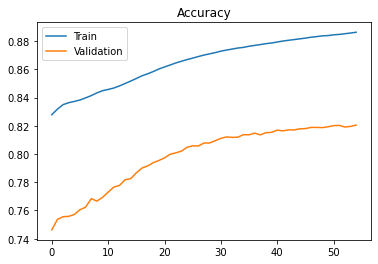

In [29]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.legend()
plt.title('Accuracy');

In [30]:
plt.plot(history2.history['accuracy'], label='Train')
plt.plot(history2.history['val_accuracy'], label='Validation')
plt.legend()
plt.title('Accuracy');

NameError: name 'history2' is not defined

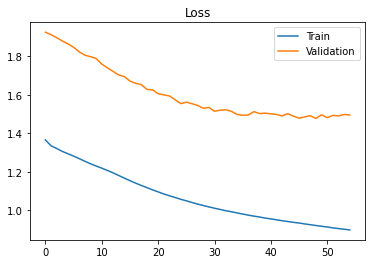

In [31]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend()
plt.title('Loss');

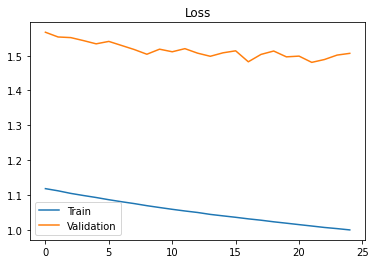

In [46]:
plt.plot(history2.history['loss'], label='Train')
plt.plot(history2.history['val_loss'], label='Validation')
plt.legend()
plt.title('Loss');

In [32]:
from tensorflow.keras.models import Model, load_model

#training_model = load_model('training_model_v2.h5')

encoder_inputs = training_model.input[0]
encoder_outputs, state_h_enc, state_c_enc = training_model.layers[2].output
encoder_states = [state_h_enc, state_c_enc]

encoder_model = Model(encoder_inputs, encoder_states)

latent_dim = 256
decoder_state_input_hidden = Input(shape=(latent_dim,))
decoder_state_input_cell = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_hidden, decoder_state_input_cell]
decoder_outputs, state_hidden, state_cell = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_hidden, state_cell]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

In [33]:
def string_to_matrix(user_input):
    '''This function takes in a string and outputs the corresponding matrix'''
    tokens = re.findall(r"[\w']+|[^\s\w]", user_input)
    user_input_matrix = np.zeros((1, max_encoder_seq_length, num_encoder_tokens), dtype='float32')
    for timestep, token in enumerate(tokens):
        if token in input_features_dict:
            user_input_matrix[0, timestep, input_features_dict[token]] = 1.
    return user_input_matrix

In [34]:
training_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 4872)] 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 6030)] 0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 256), (None, 5252096     input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 256),  6437888     input_2[0][0]                    
                                                                 lstm[0][1]                   

In [35]:
def decode_sequence(test_input):
    '''This function takes in a sentence and returns the decoded sentence'''
    
    # Encode the input as state vectors.
    states_value = encoder_model.predict(string_to_matrix(test_input))

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first token of target sequence with the start token.
    target_seq[0, 0, target_features_dict['<START>']] = 1.

    # Sampling loop for a batch of sequences
    decoded_sentence = ''

    stop_condition = False
    while not stop_condition:
        # Run the decoder model to get possible output tokens (with probabilities) & states
        output_tokens, hidden_state, cell_state = decoder_model.predict([target_seq] + states_value)

        # Choose token with highest probability and append it to decoded sentence
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_features_dict[sampled_token_index]
        decoded_sentence += " " + sampled_token

        # Exit condition: either hit max length or find stop token.
        if (sampled_token == '<END>' or len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [hidden_state, cell_state]

    return decoded_sentence

In [36]:
# Example decoded sentence
decode_sequence('we are playing')

' the <END>'

In [37]:
# Example decoded sentence
decode_sequence('it is ')

' good <END>'

In [54]:
# Example decoded sentence
decode_sequence('tomorrow is going')

' to you <END>'